# Metric Variance Analysis

This notebook analyzes the variance in final pareto volume across runs to understand:
1. Which equations have runs with zero pareto volume
2. The distribution of variance metrics across equations
3. Correlation of variance metrics between different setups

In [52]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import polars as pl
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

# Add the src directory to the path
sys.path.append('/cephfs/home/lc865/workspace/similar-expressions/src')

# Import our plotting utilities
from SR_benchmarking.analysis.plotting_utils import (
    identify_zero_pareto_volume_equations,
    add_zero_volume_markers
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

Load the final results data from the main analysis notebook.

In [53]:
# Define both experiment paths
experiment_paths = {
    'trial_1759168755656049': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/optuna_experiment/trial_1759168755656049',
    'trial_1759233537178506': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/optuna_experiment/trial_1759233537178506',
    # 'neural': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-neural',
    # 'vanilla': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-vanilla',
    # 'neural-4tasks': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-test-4',
}

# Check if parquet files exist and load them, otherwise load from CSV files
all_data = []
for setup_name, experiment_path in experiment_paths.items():
    processed_dir = os.path.join(experiment_path, 'processed')
    parquet_filename = 'combined_tensorboard_data.parquet'
    parquet_path = os.path.join(processed_dir, parquet_filename)
    
    if os.path.exists(parquet_path):
        # Load from existing parquet file using pandas to avoid schema issues
        print(f"Loading {setup_name} data from parquet file: {parquet_path}")
        df = pd.read_parquet(parquet_path)
        all_data.append(df)
    else:
        # Load from individual CSV files using pandas for consistent schema handling
        print(f"Parquet file not found, loading {setup_name} data from CSV files")
        run_names = [run_name for run_name in os.listdir(experiment_path) 
                    if run_name.startswith('pysr-univariate_eq') and '_run' in run_name]
        
        csv_data = []
        for run_name in tqdm(run_names, desc=f"Loading {setup_name} tensorboard data"):
            csv_path = os.path.join(experiment_path, run_name, 'tensorboard_scalars.csv')
            if os.path.exists(csv_path):
                # Use pandas for consistent schema handling
                df = pd.read_csv(csv_path)
                df['run_name'] = run_name
                df['setup'] = setup_name
                csv_data.append(df)
        
        if csv_data:
            # Combine all CSV data with pandas, using outer join to handle column mismatches
            combined_setup_df = pd.concat(csv_data, ignore_index=True, sort=False)
            
            # Save to parquet file for future use
            os.makedirs(processed_dir, exist_ok=True)
            combined_setup_df.to_parquet(parquet_path)
            print(f"Saved parquet file: {parquet_path}")
            
            all_data.append(combined_setup_df)

# Combine all dataframes into one large table, using outer join to handle different column sets
combined_df = pd.concat(all_data, ignore_index=True, sort=False)

# Only process the data if we loaded from CSV files
if not all(os.path.exists(os.path.join(experiment_paths[setup], 'processed', 'combined_tensorboard_data.parquet')) 
           for setup in experiment_paths.keys()):
    # Extract dataset, equation, and run number from run_name
    combined_df[['dataset', 'eq', 'run']] = combined_df['run_name'].str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)')
    combined_df['eq'] = combined_df['eq'].astype(int)
    combined_df['run'] = combined_df['run'].astype(int)

    LOSS_LOWER_BOUND = 1e-8
    combined_df['min_loss'] = combined_df['min_loss'].clip(lower=LOSS_LOWER_BOUND)
    loss_columns = [col for col in combined_df.columns if col.startswith('loss_') and col[5:].isdigit()]
    for col in loss_columns:
        combined_df[col] = combined_df[col].clip(lower=LOSS_LOWER_BOUND)

print(f"Loaded data from {len(all_data)} runs with {len(combined_df)} total rows")
print(f"Setup distribution: {combined_df['setup'].value_counts().to_dict()}")

Loading trial_1759168755656049 data from parquet file: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/optuna_experiment/trial_1759168755656049/processed/combined_tensorboard_data.parquet
Loading trial_1759233537178506 data from parquet file: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/optuna_experiment/trial_1759233537178506/processed/combined_tensorboard_data.parquet
Loaded data from 2 runs with 746172 total rows
Setup distribution: {'trial_1759168755656049': 374018, 'trial_1759233537178506': 372154}


In [54]:
# Define the steps at which to extract results
EVALUATION_STEPS = [100, 300, 600, 929]  # 929 is the final step

print("Processing all evaluation steps...")
start_time = time.time()

# Convert to polars for much faster processing
pl_df = pl.from_pandas(combined_df)

# For each evaluation step, compute cumulative metrics
result_frames = []

# First, get the final (overall) results
final_results = pl_df.group_by(['run_name', 'setup']).agg([
    pl.col('step').max().alias('final_step'),
    pl.col('min_loss').min().alias('final_min_loss'),
    pl.col('pareto_volume').max().alias('final_pareto_volume')
])

result_frames.append(final_results)

# For each evaluation step, compute metrics up to that step
for eval_step in EVALUATION_STEPS:
    step_results = (
        pl_df
        .filter(pl.col('step') <= eval_step)
        .group_by(['run_name', 'setup'])
        .agg([
            pl.col('step').max().alias(f'actual_step_{eval_step}'),
            pl.col('min_loss').min().alias(f'min_loss_step_{eval_step}'),
            pl.col('pareto_volume').max().alias(f'max_pareto_volume_step_{eval_step}')
        ])
    )
    result_frames.append(step_results)

# Join all results together
final_results_pl = result_frames[0]
for frame in result_frames[1:]:
    final_results_pl = final_results_pl.join(frame, on=['run_name', 'setup'], how='left')

# Handle runs that might not have data for early steps (fill with first available data)
# For any null values, we'll fill them after converting to pandas
final_results_df = final_results_pl.to_pandas()

# Fill NaN values with the first available data point for each run
for eval_step in EVALUATION_STEPS:
    # If actual_step is NaN, use final_step
    mask = final_results_df[f'actual_step_{eval_step}'].isna()
    if mask.any():
        final_results_df.loc[mask, f'actual_step_{eval_step}'] = final_results_df.loc[mask, 'final_step']
        final_results_df.loc[mask, f'min_loss_step_{eval_step}'] = final_results_df.loc[mask, 'final_min_loss']
        final_results_df.loc[mask, f'max_pareto_volume_step_{eval_step}'] = final_results_df.loc[mask, 'final_pareto_volume']

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Final results table with {len(final_results_df)} runs and results at steps {EVALUATION_STEPS}")
final_results_df.head()

Processing all evaluation steps...
Processing completed in 0.45 seconds
Final results table with 999 runs and results at steps [100, 300, 600, 929]


,run_name,setup,final_step,final_min_loss,final_pareto_volume,actual_step_100,min_loss_step_100,max_pareto_volume_step_100,actual_step_300,min_loss_step_300,max_pareto_volume_step_300,actual_step_600,min_loss_step_600,max_pareto_volume_step_600,actual_step_929,min_loss_step_929,max_pareto_volume_step_929
0,pysr-univariate_eq18_run2,trial_1759168755656049,3,6.981880e-09,9.118432,3,6.981880e-09,9.118432,3,6.981880e-09,9.118432,3,6.981880e-09,9.118432,3,6.981880e-09,9.118432
1,pysr-univariate_eq54_run0,trial_1759168755656049,929,2.174135e-05,8.870635,100,2.191842e-05,8.870635,300,2.182372e-05,8.870635,600,2.176052e-05,8.870635,929,2.174135e-05,8.870635
2,pysr-univariate_eq81_run1,trial_1759168755656049,929,1.410811e-06,2.892608,100,1.073282e-05,2.465044,300,6.805168e-06,2.551653,600,2.150367e-06,2.843806,929,1.410811e-06,2.892608
3,pysr-univariate_eq24_run0,trial_1759233537178506,929,1.651203e-03,9.122994,100,1.673139e-03,9.122994,300,1.662675e-03,9.122994,600,1.652891e-03,9.122994,929,1.651203e-03,9.122994
4,pysr-univariate_eq48_run2,trial_1759233537178506,929,1.740998e-05,4.070127,100,1.376547e-03,3.341451,300,1.192663e-04,3.732533,600,1.744132e-05,4.068181,929,1.740998e-05,4.070127


In [55]:
# Load equation metadata (for eval_std) - do this early so it's available throughout
eq_df = pd.read_csv('/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/dataset/PySR-univariate.csv')
print(f"Loaded metadata for {len(eq_df)} equations")
print(f"Eval std range: {eq_df['eval_std'].min():.2e} to {eq_df['eval_std'].max():.2e}")

Loaded metadata for 2018 equations
Eval std range: 0.00e+00 to 7.62e+17


## Identify Equations with Zero Pareto Volume

In [56]:
# Extract metadata if not already done
if 'eq' not in final_results_df.columns:
    final_results_df[['dataset', 'eq', 'run']] = final_results_df['run_name'].str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)')
    final_results_df['eq'] = final_results_df['eq'].astype(int)
    final_results_df['run'] = final_results_df['run'].astype(int)

# Find all runs with 0.0 final pareto volume
zero_pv_runs = final_results_df[final_results_df['final_pareto_volume'] == 0.0].copy()

# Get unique equations with at least one zero PV run
zero_pv_equations = zero_pv_runs['eq'].unique()

print(f"=== EQUATIONS WITH ZERO PARETO VOLUME RUNS ===")
print(f"Total equations with at least one 0.0 final pareto volume: {len(zero_pv_equations)}")
print()

# For each equation with zero PV, count occurrences by setup
zero_pv_summary = zero_pv_runs.groupby(['eq', 'setup']).size().reset_index(name='count')

# Pivot to get counts per setup as columns
zero_pv_pivot = zero_pv_summary.pivot(index='eq', columns='setup', values='count').fillna(0).astype(int)

# Calculate total count and mean across setups
zero_pv_pivot['total'] = zero_pv_pivot.sum(axis=1)
zero_pv_pivot['mean'] = zero_pv_pivot.mean(axis=1)

# Sort by total count descending
zero_pv_pivot = zero_pv_pivot.sort_values('total', ascending=False)

print(f"Zero Pareto Volume run counts by equation and setup:")
zero_pv_pivot

=== EQUATIONS WITH ZERO PARETO VOLUME RUNS ===
Total equations with at least one 0.0 final pareto volume: 6

Zero Pareto Volume run counts by equation and setup:


setup,trial_1759168755656049,trial_1759233537178506,total,mean
eq,,,,
0,3,4,7,4.666667
31,3,0,3,2.000000
82,2,1,3,2.000000
78,3,0,3,2.000000
28,0,2,2,1.333333
89,0,1,1,0.666667


## Variance Metrics Distribution

=== EQUATIONS WITH ZERO PARETO VOLUME RUNS ===
Total equations with at least one zero pareto volume run: 6
Equation IDs: [np.int64(0), np.int64(28), np.int64(31), np.int64(78), np.int64(82), np.int64(89)]



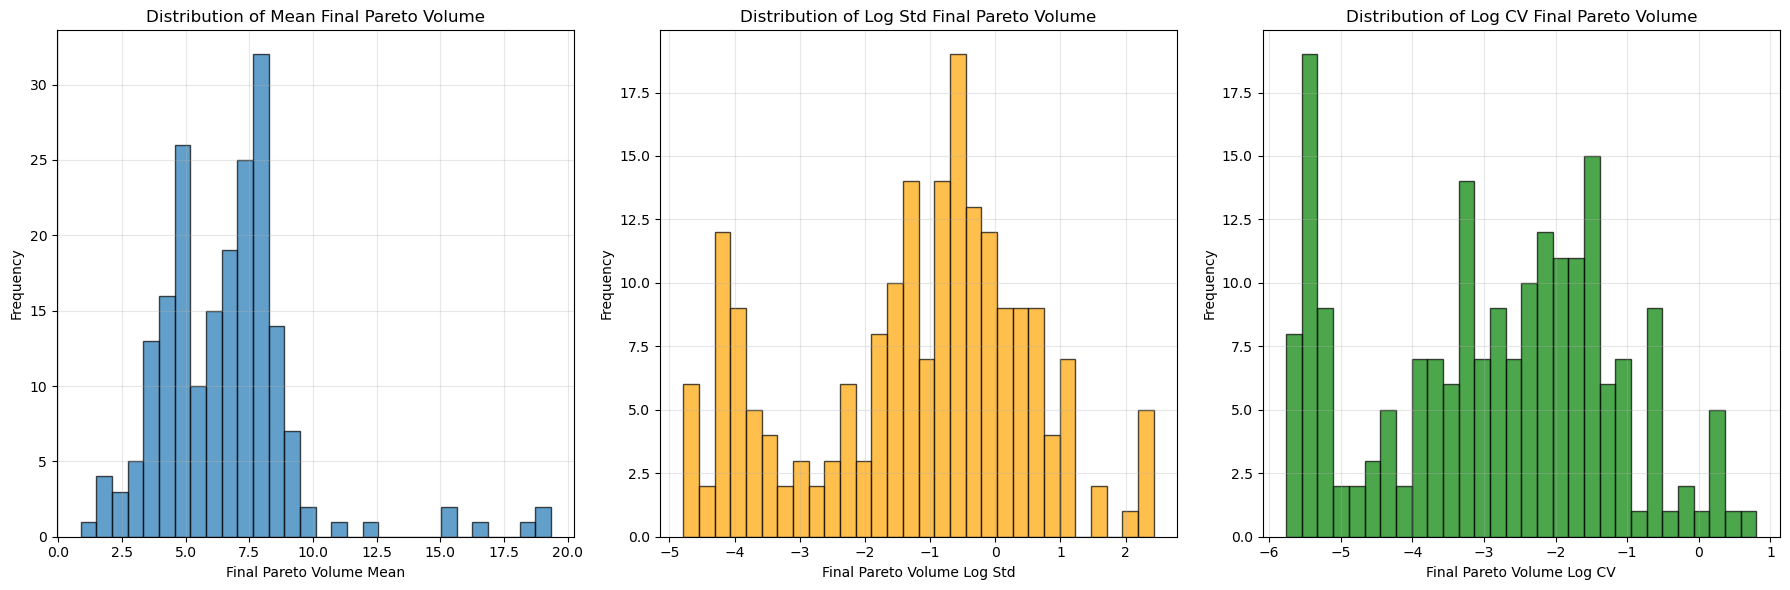

In [57]:
pl_results = pl.from_pandas(final_results_df)

# Extract metadata more efficiently
pl_results = pl_results.with_columns([
    pl.col('run_name').str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)', 1).alias('dataset'),
    pl.col('run_name').str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)', 2).cast(pl.Int64).alias('eq'),
    pl.col('run_name').str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)', 3).cast(pl.Int64).alias('run')
])

# Identify equations with zero pareto volume runs
zero_volume_equations = identify_zero_pareto_volume_equations(pl_results.to_pandas())

print(f"=== EQUATIONS WITH ZERO PARETO VOLUME RUNS ===")
print(f"Total equations with at least one zero pareto volume run: {len(zero_volume_equations)}")
print(f"Equation IDs: {sorted(zero_volume_equations)}")
print()

# Calculate mean, std, and coefficient of variance of final_pareto_volume for each equation
eps = np.exp(-6)
eq_stats = pl_results.group_by(['dataset', 'eq', 'setup']).agg([
    pl.col('final_pareto_volume').mean().alias('final_pareto_volume_mean'),
    pl.col('final_pareto_volume').std().alias('final_pareto_volume_std')
]).with_columns([
    (pl.col('final_pareto_volume_std') / pl.col('final_pareto_volume_mean')).alias('final_pareto_volume_cv'),
    (pl.col('final_pareto_volume_std') + eps).log().alias('final_pareto_volume_log_std'),
    ((pl.col('final_pareto_volume_std') / pl.col('final_pareto_volume_mean')) + eps).log().alias('final_pareto_volume_log_cv')
]).sort(['dataset', 'eq', 'setup'])

# Plot distributions of mean, log std, and log coefficient of variance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Convert to pandas for plotting
eq_stats_pd = eq_stats.to_pandas()

# Plot mean distribution
axes[0].hist(eq_stats_pd['final_pareto_volume_mean'], bins=30, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Final Pareto Volume Mean')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Mean Final Pareto Volume')
axes[0].grid(True, alpha=0.3)

# Plot log std distribution
axes[1].hist(eq_stats_pd['final_pareto_volume_log_std'], bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Final Pareto Volume Log Std')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log Std Final Pareto Volume')
axes[1].grid(True, alpha=0.3)

# Plot log coefficient of variance distribution
axes[2].hist(eq_stats_pd['final_pareto_volume_log_cv'], bins=30, alpha=0.7, edgecolor='black', color='green')
axes[2].set_xlabel('Final Pareto Volume Log CV')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Log CV Final Pareto Volume')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Correlation Between Setups

Equations with zero PV runs: 6
Equations with zero/very low eval_std: 90
Equations with both issues: 4


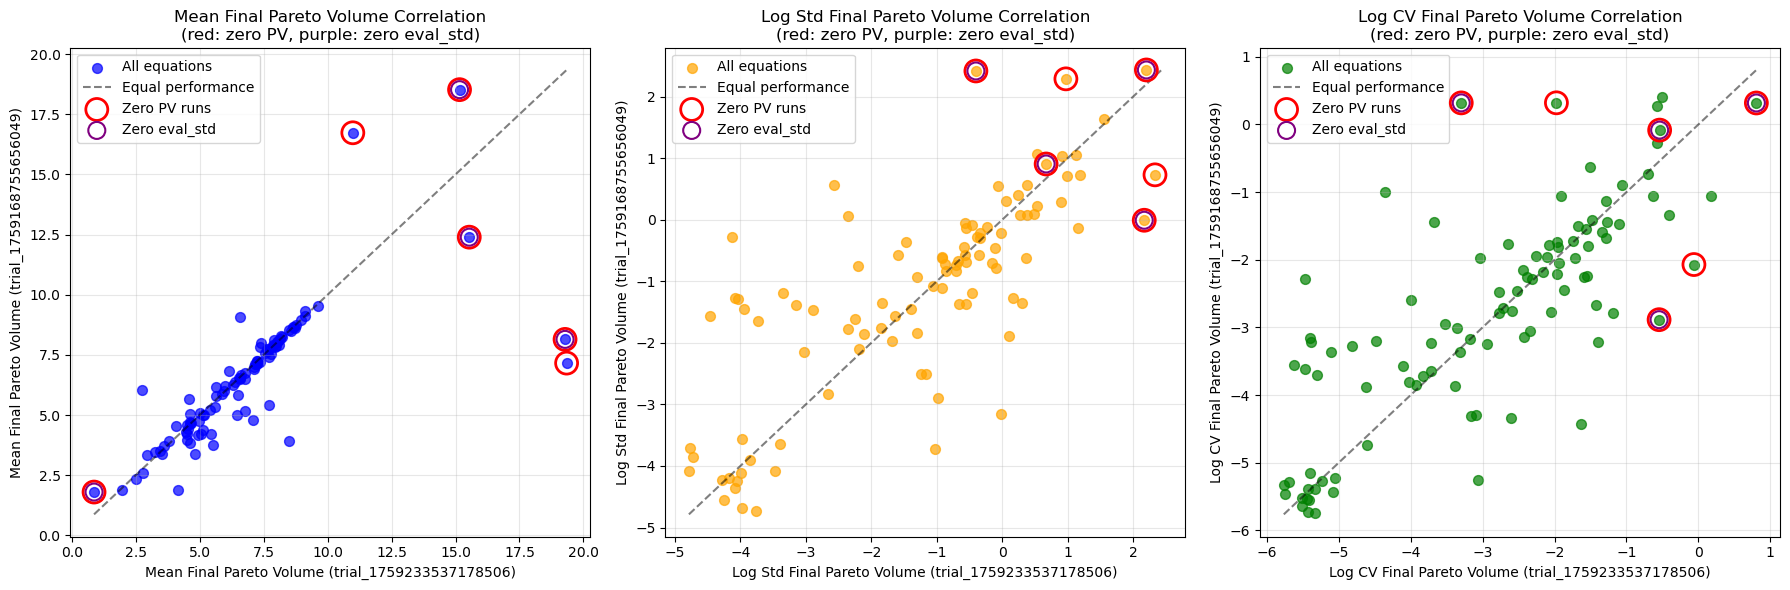

In [58]:
# Identify bad equations separately for zero PV and zero eval_std
zero_pv_equations_for_plot = set()
zero_eval_std_equations_for_plot = set()

# Add equations with zero PV runs
if 'eq' in final_results_df.columns:
    zero_pv_runs_temp = final_results_df[final_results_df['final_pareto_volume'] == 0.0]
    zero_pv_equations_for_plot = set(zero_pv_runs_temp['eq'].unique())

# Add equations with zero or very low eval_std
zero_eval_std_threshold = 1e-10
zero_eval_std_equations_for_plot = set(eq_df[eq_df['eval_std'] < zero_eval_std_threshold].index)

print(f"Equations with zero PV runs: {len(zero_pv_equations_for_plot)}")
print(f"Equations with zero/very low eval_std: {len(zero_eval_std_equations_for_plot)}")
print(f"Equations with both issues: {len(zero_pv_equations_for_plot & zero_eval_std_equations_for_plot)}")

# Create correlation plots with both types of bad equations marked
setup_comparison_marked = eq_stats.pivot(
    index=['dataset', 'eq'], 
    on='setup', 
    values=['final_pareto_volume_mean', 'final_pareto_volume_log_std', 'final_pareto_volume_log_cv']
)

# Convert to pandas and flatten column names
setup_comparison_marked_pd = setup_comparison_marked.to_pandas()

# Flatten column names if they are MultiIndex
if isinstance(setup_comparison_marked_pd.columns, pd.MultiIndex):
    setup_comparison_marked_pd.columns = ['_'.join(str(col).strip() for col in cols) for cols in setup_comparison_marked_pd.columns.values]

setup_comparison_marked_pd = setup_comparison_marked_pd.reset_index()

# Mark bad equations
setup_comparison_marked_pd['is_zero_pv'] = setup_comparison_marked_pd['eq'].isin(zero_pv_equations_for_plot)
setup_comparison_marked_pd['is_zero_eval'] = setup_comparison_marked_pd['eq'].isin(zero_eval_std_equations_for_plot)

# Get the two setup names dynamically
setup_names = eq_stats['setup'].unique().to_list()
setup1, setup2 = setup_names[0], setup_names[1]

# Create correlation plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot with both types of markers
def plot_with_markers(ax, data, col1, col2, color='blue', title='', xlabel='', ylabel=''):
    valid_data = data.dropna(subset=[col1, col2])
    
    if len(valid_data) == 0:
        return
    
    # Plot all points
    ax.scatter(valid_data[col1], valid_data[col2], alpha=0.7, s=50, color=color, label='All equations')
    
    # Add diagonal line
    max_val = max(valid_data[col1].max(), valid_data[col2].max())
    min_val = min(valid_data[col1].min(), valid_data[col2].min())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Equal performance')
    
    # Add markers for zero PV equations (red circles, larger)
    zero_pv_data = valid_data[valid_data['is_zero_pv']]
    if len(zero_pv_data) > 0:
        ax.scatter(zero_pv_data[col1], zero_pv_data[col2], 
                  s=250, facecolors='none', edgecolors='red', linewidths=2,
                  label='Zero PV runs', zorder=10)
    
    # Add markers for zero eval_std equations (purple circles, smaller, offset slightly)
    zero_eval_data = valid_data[valid_data['is_zero_eval']]
    if len(zero_eval_data) > 0:
        # For points that have both issues, we want the purple circle to be inside the red one
        ax.scatter(zero_eval_data[col1], zero_eval_data[col2], 
                  s=150, facecolors='none', edgecolors='purple', linewidths=1.5,
                  label='Zero eval_std', zorder=11)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

# Mean correlation
mean_col1 = f'final_pareto_volume_mean_{setup1}'
mean_col2 = f'final_pareto_volume_mean_{setup2}'
plot_with_markers(
    axes[0], setup_comparison_marked_pd, mean_col1, mean_col2,
    color='blue',
    title='Mean Final Pareto Volume Correlation\n(red: zero PV, purple: zero eval_std)',
    xlabel=f'Mean Final Pareto Volume ({setup1})',
    ylabel=f'Mean Final Pareto Volume ({setup2})'
)

# Log Std correlation
log_std_col1 = f'final_pareto_volume_log_std_{setup1}'
log_std_col2 = f'final_pareto_volume_log_std_{setup2}'
plot_with_markers(
    axes[1], setup_comparison_marked_pd, log_std_col1, log_std_col2,
    color='orange',
    title='Log Std Final Pareto Volume Correlation\n(red: zero PV, purple: zero eval_std)',
    xlabel=f'Log Std Final Pareto Volume ({setup1})',
    ylabel=f'Log Std Final Pareto Volume ({setup2})'
)

# Log CV correlation
log_cv_col1 = f'final_pareto_volume_log_cv_{setup1}'
log_cv_col2 = f'final_pareto_volume_log_cv_{setup2}'
plot_with_markers(
    axes[2], setup_comparison_marked_pd, log_cv_col1, log_cv_col2,
    color='green',
    title='Log CV Final Pareto Volume Correlation\n(red: zero PV, purple: zero eval_std)',
    xlabel=f'Log CV Final Pareto Volume ({setup1})',
    ylabel=f'Log CV Final Pareto Volume ({setup2})'
)

plt.tight_layout()
plt.show()

In [59]:
# Load equation metadata (for eval_std)
eq_df = pd.read_csv('/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/dataset/PySR-univariate.csv')

# Extract early stopping information from final_results_df
# Early stopping means final_step < max_step for that trial
# First, find the max step for each setup
max_steps_per_setup = final_results_df.groupby('setup')['final_step'].max().to_dict()
print("Max steps per setup:")
print(max_steps_per_setup)
print()

# Add early_stopped flag and eval_std to final_results_df
if 'eq' not in final_results_df.columns:
    final_results_df[['dataset', 'eq', 'run']] = final_results_df['run_name'].str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)')
    final_results_df['eq'] = final_results_df['eq'].astype(int)
    final_results_df['run'] = final_results_df['run'].astype(int)

# Add early_stopped flag
final_results_df['early_stopped'] = final_results_df.apply(
    lambda row: row['final_step'] < max_steps_per_setup.get(row['setup'], 929), 
    axis=1
)

# Merge with equation metadata to get eval_std
final_results_df = final_results_df.merge(
    eq_df[['eval_std']].reset_index().rename(columns={'index': 'eq'}),
    on='eq',
    how='left'
)

# Calculate early stopping statistics by equation
early_stop_stats = final_results_df.groupby(['eq', 'setup']).agg({
    'early_stopped': 'sum',  # Count of early stopped runs
    'final_step': ['mean', 'std', 'min', 'max'],  # Step statistics
    'run': 'count'  # Total runs
}).reset_index()

early_stop_stats.columns = ['eq', 'setup', 'early_stopped_count', 'mean_steps', 'std_steps', 'min_steps', 'max_steps', 'total_runs']
early_stop_stats['early_stop_fraction'] = early_stop_stats['early_stopped_count'] / early_stop_stats['total_runs']

# Merge eval_std
early_stop_stats = early_stop_stats.merge(
    eq_df[['eval_std']].reset_index().rename(columns={'index': 'eq'}),
    on='eq',
    how='left'
)

# Calculate variance metrics by equation
variance_stats = final_results_df.groupby(['eq', 'setup']).agg({
    'final_pareto_volume': ['mean', 'std', lambda x: (x == 0.0).sum()]  # Count zeros
}).reset_index()

variance_stats.columns = ['eq', 'setup', 'pv_mean', 'pv_std', 'zero_pv_count']
variance_stats['pv_cv'] = variance_stats['pv_std'] / variance_stats['pv_mean']

# Merge all stats together
combined_stats = early_stop_stats.merge(variance_stats, on=['eq', 'setup'], how='inner')

print(f"Combined statistics for {len(combined_stats)} equation-setup combinations")
print()
print("Sample of combined stats:")
print(combined_stats.head(10).to_string())
print()

# Identify high variance equations (top 25% by CV)
high_var_threshold = combined_stats['pv_cv'].quantile(0.75)
combined_stats['high_variance'] = combined_stats['pv_cv'] > high_var_threshold

print(f"High variance threshold (75th percentile CV): {high_var_threshold:.3f}")
print(f"Equations with high variance: {combined_stats['high_variance'].sum()}")
print(f"Equations with zero PV: {(combined_stats['zero_pv_count'] > 0).sum()}")

Max steps per setup:
{'trial_1759168755656049': 929, 'trial_1759233537178506': 929}

Combined statistics for 200 equation-setup combinations

Sample of combined stats:
   eq                   setup  early_stopped_count  mean_steps   std_steps  min_steps  max_steps  total_runs  early_stop_fraction      eval_std   pv_mean    pv_std  zero_pv_count     pv_cv
0   0  trial_1759168755656049                    5         1.0    0.000000          1          1           5                  1.0  5.551115e-17  1.799390  2.468067              3  1.371613
1   0  trial_1759233537178506                    5         1.2    0.447214          1          2           5                  1.0  5.551115e-17  0.872388  1.950719              4  2.236068
2   1  trial_1759168755656049                    0       929.0    0.000000        929        929           5                  0.0  9.325325e+00  7.161232  0.078632              0  0.010980
3   1  trial_1759233537178506                    0       929.0    0.000000  

In [60]:
# Print detailed breakdown by category
print("\n=== BREAKDOWN BY CATEGORY ===\n")

# High variance equations
print("HIGH VARIANCE EQUATIONS:")
high_var_eqs = combined_stats[combined_stats['high_variance']]
print(f"  Total: {len(high_var_eqs)}")
print(f"  Mean early stop fraction: {high_var_eqs['early_stop_fraction'].mean():.3f}")
print(f"  Mean zero PV count: {high_var_eqs['zero_pv_count'].mean():.2f}")
print(f"  Mean eval std: {high_var_eqs['eval_std'].mean():.4f}")
print()

# Equations with zero PV
print("EQUATIONS WITH ZERO PV:")
zero_pv_eqs = combined_stats[combined_stats['zero_pv_count'] > 0]
print(f"  Total: {len(zero_pv_eqs)}")
print(f"  Mean early stop fraction: {zero_pv_eqs['early_stop_fraction'].mean():.3f}")
print(f"  Mean PV CV: {zero_pv_eqs['pv_cv'].mean():.3f}")
print(f"  Mean eval std: {zero_pv_eqs['eval_std'].mean():.4f}")
print()

# High early stopping (>50% of runs stopped early)
print("HIGH EARLY STOPPING (>50% of runs):")
high_early_stop = combined_stats[combined_stats['early_stop_fraction'] > 0.5]
print(f"  Total: {len(high_early_stop)}")
print(f"  Mean PV CV: {high_early_stop['pv_cv'].mean():.3f}")
print(f"  Mean zero PV count: {high_early_stop['zero_pv_count'].mean():.2f}")
print(f"  Mean eval std: {high_early_stop['eval_std'].mean():.4f}")
print()

# Print top 10 equations with highest zero PV counts
print("TOP 10 EQUATIONS WITH MOST ZERO PV RUNS:")
top_zero_pv = combined_stats.nlargest(10, 'zero_pv_count')[
    ['eq', 'setup', 'zero_pv_count', 'total_runs', 'early_stop_fraction', 'pv_cv', 'eval_std', 'mean_steps']
]
print(top_zero_pv.to_string(index=False))


=== BREAKDOWN BY CATEGORY ===

HIGH VARIANCE EQUATIONS:
  Total: 50
  Mean early stop fraction: 0.416
  Mean zero PV count: 0.38
  Mean eval std: 392359.2877

EQUATIONS WITH ZERO PV:
  Total: 8
  Mean early stop fraction: 1.000
  Mean PV CV: 1.171
  Mean eval std: 0.0153

HIGH EARLY STOPPING (>50% of runs):
  Total: 44
  Mean PV CV: 0.396
  Mean zero PV count: 0.43
  Mean eval std: 300174.8884

TOP 10 EQUATIONS WITH MOST ZERO PV RUNS:
 eq                  setup  zero_pv_count  total_runs  early_stop_fraction    pv_cv     eval_std  mean_steps
  0 trial_1759233537178506              4           5                  1.0 2.236068 5.551115e-17         1.2
  0 trial_1759168755656049              3           5                  1.0 1.371613 5.551115e-17         1.0
 31 trial_1759168755656049              3           5                  1.0 1.373341 0.000000e+00         1.0
 78 trial_1759168755656049              3           5                  1.0 1.374737 1.071709e-01         1.0
 28 trial_17592

## Good Equations for Hyperparameter Tuning

Filter out "bad equations" (those with zero PV runs or zero eval_std) and get the first 100 good equations.

In [61]:
# Identify bad equations (those with zero PV runs or zero/very low eval_std)
bad_equations = set()

# Add equations with zero PV runs
zero_pv_equations_set = set(combined_stats[combined_stats['zero_pv_count'] > 0]['eq'].unique())
bad_equations.update(zero_pv_equations_set)

# Add equations with zero or very low eval_std (likely problematic)
zero_eval_std_threshold = 1e-10  # Essentially zero
zero_eval_std_equations = set(eq_df[eq_df['eval_std'] < zero_eval_std_threshold].index)
bad_equations.update(zero_eval_std_equations)

print(f"=== BAD EQUATIONS SUMMARY ===")
print(f"Equations with zero PV runs: {len(zero_pv_equations_set)}")
print(f"Equations with zero/very low eval_std (< {zero_eval_std_threshold}): {len(zero_eval_std_equations)}")
print(f"Total bad equations (union): {len(bad_equations)}")
print()

# Get all equation IDs from the dataset
all_equations = set(range(len(eq_df)))

# Filter out bad equations
good_equations = sorted(all_equations - bad_equations)

print(f"Total equations in dataset: {len(all_equations)}")
print(f"Good equations: {len(good_equations)}")
print()

# Get first 100 good equations
first_100_good = good_equations[:100]

print(f"First 100 good equations for hyperparameter tuning:")
print(','.join(map(str, first_100_good)))
print()

# Also print some statistics about the good equations
print(f"\n=== GOOD EQUATIONS STATISTICS ===")
good_eq_stats = combined_stats[combined_stats['eq'].isin(first_100_good)]
print(f"Mean PV CV: {good_eq_stats['pv_cv'].mean():.3f}")
print(f"Mean early stop fraction: {good_eq_stats['early_stop_fraction'].mean():.3f}")
print(f"Mean eval std: {good_eq_stats['eval_std'].mean():.4f}")

=== BAD EQUATIONS SUMMARY ===
Equations with zero PV runs: 6
Equations with zero/very low eval_std (< 1e-10): 90
Total bad equations (union): 92

Total equations in dataset: 2018
Good equations: 1926

First 100 good equations for hyperparameter tuning:
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,79,80,81,83,84,85,86,87,88,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105


=== GOOD EQUATIONS STATISTICS ===
Mean PV CV: 0.133
Mean early stop fraction: 0.182
Mean eval std: 208633.6834


## Variance in Estimator of Mean PV Across Equations

Analyze the variance in our estimator when we want to estimate the mean PV over all equations.
Assumes PV for each equation is Gaussian distributed with different mean and std for each equation.

=== VARIANCE IN ESTIMATOR OF MEAN PV ACROSS EQUATIONS ===
Remove bad equations: True

Identifying bad equations...
  Equations with zero PV: 6
  Equations with zero eval_std: 90
  Total bad equations: 92

Analyzing 188 equation-setup combinations

RESULTS BY SETUP:

Setup: trial_1759168755656049
  Number of equations: 94
  Mean runs per equation: 5.0
  ---
  Grand mean (estimate): 6.1270
  Estimator variance: 0.002127
  Estimator std: 0.0461
  Estimator CV: 0.0075
  95% CI: [6.0366, 6.2174]
  ---
  Mean equation std: 0.6116

Setup: trial_1759233537178506
  Number of equations: 94
  Mean runs per equation: 5.0
  ---
  Grand mean (estimate): 6.2916
  Estimator variance: 0.002476
  Estimator std: 0.0498
  Estimator CV: 0.0079
  95% CI: [6.1941, 6.3891]
  ---
  Mean equation std: 0.6514


SUMMARY TABLE:
                 setup  n_equations  grand_mean  estimator_variance  estimator_std  estimator_cv  mean_runs_per_eq  mean_eq_std
trial_1759168755656049           94    6.126963            0.

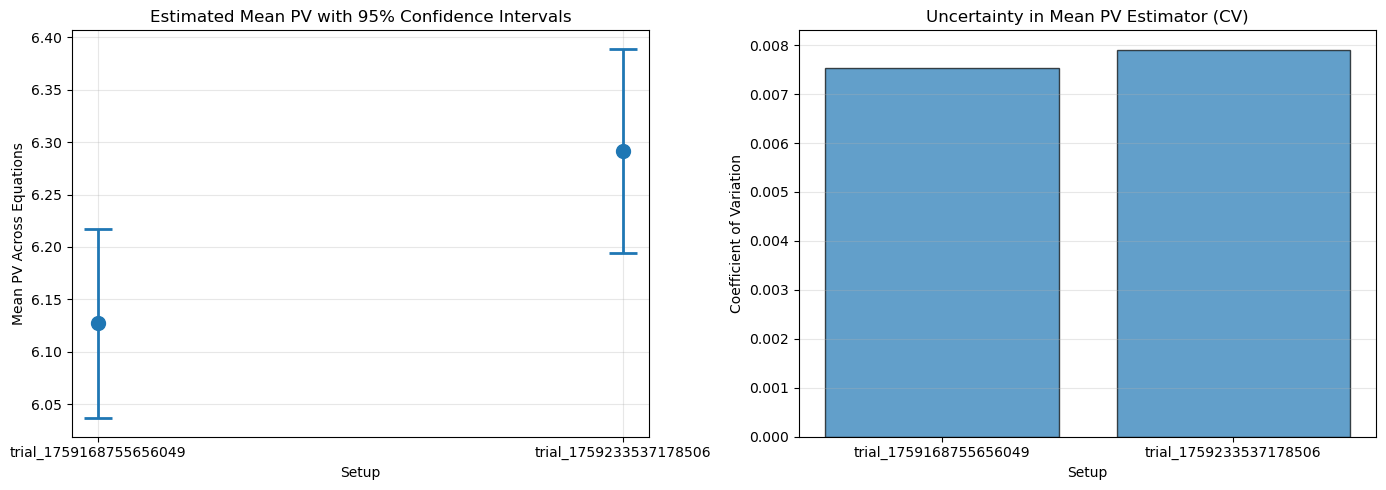


VARIANCE BREAKDOWN:

trial_1759168755656049:
  Total variance contribution: 18.792836
  Divided by N^2 (94^2 = 8836): 0.002127
  Average variance per equation: 0.199924
  Std of variance across equations: 0.615041
  Max variance contribution: 5.272354
  Min variance contribution: 0.000008

trial_1759233537178506:
  Total variance contribution: 21.877325
  Divided by N^2 (94^2 = 8836): 0.002476
  Average variance per equation: 0.232738
  Std of variance across equations: 0.607736
  Max variance contribution: 4.453647
  Min variance contribution: 0.000007


In [62]:
# Calculate variance in the estimator of mean PV across equations
# Estimator: mean over equations of (mean over runs for each equation)
# Variance formula: Var(1/N * sum_i X_i) = 1/N^2 * sum_i Var(X_i)
# where X_i is the sample mean for equation i

# Option to remove bad equations
REMOVE_BAD_EQUATIONS = True  # Set to True to exclude bad equations

print(f"=== VARIANCE IN ESTIMATOR OF MEAN PV ACROSS EQUATIONS ===")
print(f"Remove bad equations: {REMOVE_BAD_EQUATIONS}\n")

# Filter equations if requested
if REMOVE_BAD_EQUATIONS:
    print("Identifying bad equations...")
    bad_equations_filter = set()
    
    # Add equations with zero PV runs
    zero_pv_equations_filter = set(combined_stats[combined_stats['zero_pv_count'] > 0]['eq'].unique())
    bad_equations_filter.update(zero_pv_equations_filter)
    
    # Add equations with zero or very low eval_std
    zero_eval_std_threshold = 1e-10
    zero_eval_std_equations_filter = set(eq_df[eq_df['eval_std'] < zero_eval_std_threshold].index)
    bad_equations_filter.update(zero_eval_std_equations_filter)
    
    print(f"  Equations with zero PV: {len(zero_pv_equations_filter)}")
    print(f"  Equations with zero eval_std: {len(zero_eval_std_equations_filter)}")
    print(f"  Total bad equations: {len(bad_equations_filter)}\n")
    
    # Filter the stats
    filtered_stats = combined_stats[~combined_stats['eq'].isin(bad_equations_filter)].copy()
else:
    filtered_stats = combined_stats.copy()

print(f"Analyzing {len(filtered_stats)} equation-setup combinations\n")

# For each setup, calculate the variance of our estimator
results = []

for setup in filtered_stats['setup'].unique():
    setup_data = filtered_stats[filtered_stats['setup'] == setup]
    
    # Get statistics for each equation
    eq_means = setup_data['pv_mean'].values
    eq_stds = setup_data['pv_std'].values
    eq_runs = setup_data['total_runs'].values
    
    # Number of equations
    n_equations = len(eq_means)
    
    # Variance of sample mean for each equation: Var(X_bar_i) = sigma_i^2 / n_i
    var_of_sample_means = (eq_stds ** 2) / eq_runs
    
    # Variance of our estimator (mean over equations of sample means)
    # Var(1/N * sum_i X_bar_i) = 1/N^2 * sum_i Var(X_bar_i)
    estimator_variance = np.sum(var_of_sample_means) / (n_equations ** 2)
    estimator_std = np.sqrt(estimator_variance)
    
    # Calculate the grand mean (our point estimate)
    grand_mean = np.mean(eq_means)
    
    # Calculate coefficient of variation
    cv = estimator_std / grand_mean if grand_mean > 0 else np.inf
    
    # Store results
    results.append({
        'setup': setup,
        'n_equations': n_equations,
        'grand_mean': grand_mean,
        'estimator_variance': estimator_variance,
        'estimator_std': estimator_std,
        'estimator_cv': cv,
        'mean_runs_per_eq': np.mean(eq_runs),
        'mean_eq_std': np.mean(eq_stds)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("RESULTS BY SETUP:")
print("=" * 80)
for _, row in results_df.iterrows():
    print(f"\nSetup: {row['setup']}")
    print(f"  Number of equations: {row['n_equations']}")
    print(f"  Mean runs per equation: {row['mean_runs_per_eq']:.1f}")
    print(f"  ---")
    print(f"  Grand mean (estimate): {row['grand_mean']:.4f}")
    print(f"  Estimator variance: {row['estimator_variance']:.6f}")
    print(f"  Estimator std: {row['estimator_std']:.4f}")
    print(f"  Estimator CV: {row['estimator_cv']:.4f}")
    print(f"  95% CI: [{row['grand_mean'] - 1.96*row['estimator_std']:.4f}, {row['grand_mean'] + 1.96*row['estimator_std']:.4f}]")
    print(f"  ---")
    print(f"  Mean equation std: {row['mean_eq_std']:.4f}")

print("\n" + "=" * 80)
print("\nSUMMARY TABLE:")
print(results_df.to_string(index=False))

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Grand mean with error bars (95% CI)
setups = results_df['setup'].values
grand_means = results_df['grand_mean'].values
estimator_stds = results_df['estimator_std'].values

axes[0].errorbar(setups, grand_means, yerr=1.96*estimator_stds, 
                fmt='o', markersize=10, capsize=10, capthick=2, linewidth=2)
axes[0].set_xlabel('Setup')
axes[0].set_ylabel('Mean PV Across Equations')
axes[0].set_title('Estimated Mean PV with 95% Confidence Intervals')
axes[0].grid(True, alpha=0.3)

# Plot 2: Coefficient of variation comparison
axes[1].bar(setups, results_df['estimator_cv'].values, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Setup')
axes[1].set_ylabel('Coefficient of Variation')
axes[1].set_title('Uncertainty in Mean PV Estimator (CV)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Additional analysis: breakdown of variance contribution
print("\n" + "=" * 80)
print("VARIANCE BREAKDOWN:")
print("=" * 80)

for setup in filtered_stats['setup'].unique():
    setup_data = filtered_stats[filtered_stats['setup'] == setup]
    
    eq_stds = setup_data['pv_std'].values
    eq_runs = setup_data['total_runs'].values
    n_equations = len(eq_stds)
    
    var_of_sample_means = (eq_stds ** 2) / eq_runs
    
    print(f"\n{setup}:")
    print(f"  Total variance contribution: {np.sum(var_of_sample_means):.6f}")
    print(f"  Divided by N^2 ({n_equations}^2 = {n_equations**2}): {np.sum(var_of_sample_means) / (n_equations**2):.6f}")
    print(f"  Average variance per equation: {np.mean(var_of_sample_means):.6f}")
    print(f"  Std of variance across equations: {np.std(var_of_sample_means):.6f}")
    print(f"  Max variance contribution: {np.max(var_of_sample_means):.6f}")
    print(f"  Min variance contribution: {np.min(var_of_sample_means):.6f}")